In [1]:
!pip install networkx
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt
import textwrap

In [3]:
url = "http://localhost:8088/api/v1/triples-query"

In [4]:
def get_entity(label):
    
    input = {
        "p": "http://www.w3.org/2000/01/rdf-schema#label",
        "o": label,
        "limit": 1,
    }
    
    resp = requests.post(url, json=input)
    if resp.status_code != 200:
        raise RuntimeError(f"Got status code {resp.status_code}")
    try:
        resp = resp.json()
    except:
        raise RuntimeError("JSON decode failed")

    for row in resp["response"]:
        return row["s"]["v"]

    raise RuntimeError("Couldn't resolve entity")


In [5]:
def get_label(ent):

    if ent == "http://www.w3.org/2000/01/rdf-schema#label": return "label"
    if ent == "https://schema.org/subjectOf": return "subject of"
    if ent.startswith("https://trustgraph.ai/doc/"): return "source document"
    if ent == "http://www.w3.org/2004/02/skos/core#definition": return "definition"

    if not ent.startswith("http"): return ent
        
    input = {
        "s": ent,
        "p": "http://www.w3.org/2000/01/rdf-schema#label",
        "limit": 1,
    }
    
    resp = requests.post(url, json=input)
    if resp.status_code != 200:
        raise RuntimeError(f"Got status code {resp.status_code}")
    try:
        resp = resp.json()
    except:
        raise RuntimeError("JSON decode failed")

    for row in resp["response"]:
        label = row["o"]["v"]
        return label
        
    # If no label, just dump the entity
    return ent

In [6]:
def get_related_edges(s):
    
    input = {
        "s": s,
        "limit": 10,
    }
    
    resp = requests.post(url, json=input)
    if resp.status_code != 200:
        raise RuntimeError(f"Got status code {resp.status_code}")
    try:
        resp = resp.json()
    except:
        raise RuntimeError("JSON decode failed")

    return [
        [s, row["p"]["v"], row["o"]["v"]]
        for row in resp["response"]
    ]

In [7]:
accident = get_entity("Space Shuttle Challenger Accident")
shuttle = get_entity("Space Shuttle")
fuselage = get_entity("operational flights")
rocket = get_entity("rocket")
thruster = get_entity("thruster")

In [8]:
edges = []
edges.extend(get_related_edges(accident))
edges.extend(get_related_edges(shuttle))
edges.extend(get_related_edges(fuselage))
edges.extend(get_related_edges(rocket))
edges.extend(get_related_edges(thruster))

In [9]:
edges

[['http://trustgraph.ai/e/space-shuttle-challenger-accident',
  'http://trustgraph.ai/e/interrupted',
  'productive engineering, scientific and exploratory programs'],
 ['http://trustgraph.ai/e/space-shuttle-challenger-accident',
  'http://www.w3.org/2000/01/rdf-schema#label',
  'Space Shuttle Challenger Accident'],
 ['http://trustgraph.ai/e/space-shuttle-challenger-accident',
  'http://www.w3.org/2000/01/rdf-schema#label',
  'Space Shuttle Challenger accident'],
 ['http://trustgraph.ai/e/space-shuttle-challenger-accident',
  'http://www.w3.org/2004/02/skos/core#definition',
  'The event involving the destruction of the Space Shuttle Challenger, discussed in various reports and hearing transcripts.'],
 ['http://trustgraph.ai/e/space-shuttle-challenger-accident',
  'http://www.w3.org/2004/02/skos/core#definition',
  "The event that prompted the Presidential Commission's report."],
 ['http://trustgraph.ai/e/space-shuttle-challenger-accident',
  'http://www.w3.org/2004/02/skos/core#defini

In [10]:
ents = list(set([e[0] for e in edges] + [e[2] for e in edges]))

id2label = { ix: ent for ix, ent in enumerate(ents) }
label2id = { ent: ix for ix, ent in enumerate(ents) }

id2name = { ix: get_label(ent) for ix, ent in enumerate(ents) }


In [11]:
network_e = [(label2id[e[0]], label2id[e[2]]) for e in edges]

In [12]:
edge_labels = {
    (label2id[e[0]], label2id[e[2]]): get_label(e[1])
    for e in edges
}

In [13]:
# Create a directed graph using NetworkX
network = nx.DiGraph()
network.add_edges_from(network_e)

# Visualize the directed graph with real-world names as node labels
pos = nx.spring_layout(network)  # Positions for all nodes


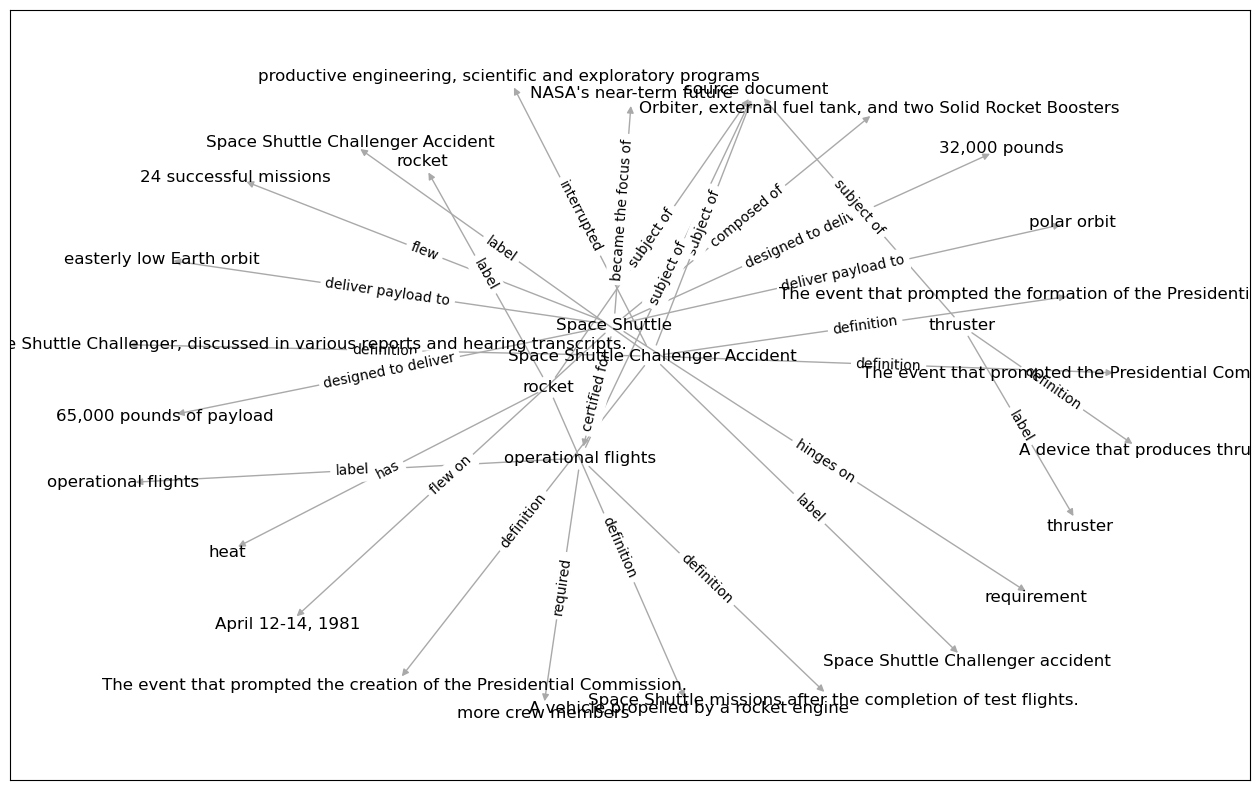

In [14]:

plt.figure(figsize=(16,10))
# nx.draw_networkx_nodes(network, pos, node_shape='o', node_color='red', node_size=50)
nx.draw_networkx_edges(network, pos, edge_color='darkgray')
nx.draw_networkx_labels(network, pos, labels=id2name)
nx.draw_networkx_edge_labels(network, pos, edge_labels=edge_labels)

plt.show()